In [1]:
import os
import pandas as pd
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

Logistic Regression (LR)

Linear Discriminant Analysis (LDA)

K-Nearest Neighbor (KNN)

Decision Tree (CART)

Naïve Bayes (NB)

Support Vector Machine (SVM)

AdaBoost (AB)

Gradient Boosting Machine (GBM)

Random Forest (RF)

Extra Trees (ET)

Multi-Layer Perceptron (MLP)

In [4]:
inner_dir = "./PTC_MR/"
edge_list = pd.read_csv(os.path.join(inner_dir, 'PTC_MR_A.txt'), header=None)
edge_labels = pd.read_csv(os.path.join(inner_dir, 'PTC_MR_edge_labels.txt'), header=None)
node_labels = pd.read_csv(os.path.join(inner_dir, 'PTC_MR_node_labels.txt'), header=None)
graph_indicator = pd.read_csv(os.path.join(inner_dir, 'PTC_MR_graph_indicator.txt'), header=None)
graph_labels = pd.read_csv(os.path.join(inner_dir, 'PTC_MR_graph_labels.txt'), header=None)

# Set column names
edge_list.columns = ['source', 'target']
edge_labels.columns = ['bond_type']
node_labels.columns = ['atom_type']
graph_indicator.columns = ['graph_id']
graph_labels.columns = ['graph_label']

preserve both node attributes (chem, charge, x, y) and bond types (valence).

In [6]:
# ========== Prepare Graphs ==========
graph_id_to_nodes = graph_indicator.reset_index().groupby('graph_id')['index'].apply(list).to_dict()

graphs = {}
for graph_id, nodes in graph_id_to_nodes.items():
    node_set = set(nodes)
    edges = edge_list[
        edge_list['source'].isin(node_set) & edge_list['target'].isin(node_set)
    ]
    G = nx.Graph()
    G.add_edges_from(edges.values)
    # Assign node labels (atom types)
    for node in nodes:
        G.add_node(node, atom_label=node_labels.iloc[node, 0])
    graphs[graph_id] = G

## Feature Engineering 

In [19]:
# Map integer node labels back to atomic numbers
int_to_symbol = {
    0: 'In', 1: 'P', 2: 'O', 3: 'N', 4: 'Na', 5: 'C', 6: 'Cl',
    7: 'S', 8: 'Br', 9: 'F', 10: 'K', 11: 'Cu', 12: 'Zn', 13: 'I',
    14: 'Ba', 15: 'Sn', 16: 'Pb', 17: 'Ca'
}

# Inverse map of integer node labels (0–37) to symbols
symbol_to_atomic_number = {
    'H': 1, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'P': 15, 'S': 16,
    'Cl': 17, 'Br': 35, 'I': 53, 'Na': 11, 'K': 19, 'Li': 3, 'Ca': 20,
    'In': 49, 'Cu': 29, 'Zn': 30, 'Ba': 56, 'Sn': 50, 'Pb': 82
}

# Edge label (0, 1, 2, 3) to bond type
edge_label_to_bondtype = {
    0: Chem.rdchem.BondType.TRIPLE,
    1: Chem.rdchem.BondType.DOUBLE,
    2: Chem.rdchem.BondType.SINGLE,
    3: Chem.rdchem.BondType.AROMATIC
}

# Updated helper
def graph_to_molecule(G):
    mol = Chem.RWMol()
    idx_map = {}

    for node, data in G.nodes(data=True):
        label_idx = int(data['atom_label'])
        symbol = int_to_symbol.get(label_idx)
        if symbol is None:
            raise ValueError(f"Unknown label {label_idx}")
        atomic_number = symbol_to_atomic_number.get(symbol)
        if atomic_number is None:
            raise ValueError(f"No atomic number for {symbol}")

        atom = Chem.Atom(atomic_number)
        atom.SetNoImplicit(True)  # Prevent RDKit from guessing valence
        idx_map[node] = mol.AddAtom(atom)

    for u, v, attr in G.edges(data=True):
        bond_label = attr.get("bond_type", 2)
        bond_type = edge_label_to_bondtype.get(bond_label, Chem.rdchem.BondType.SINGLE)
        try:
            mol.AddBond(idx_map[u], idx_map[v], bond_type)
        except:
            continue  # Skip malformed bonds

    return mol.GetMol()

In [22]:
from rdkit import Chem

# Extended valence map for more elements seen in AIDS
max_valence = {
    0: 49,   # In
    1: 15,   # P
    2: 8,    # O
    3: 7,    # N
    4: 11,   # Na
    5: 6,    # C
    6: 17,   # Cl
    7: 16,   # S
    8: 35,   # Br
    9: 9,    # F
    10: 19,  # K
    11: 29,  # Cu
    12: 30,  # Zn
    13: 53,  # I
    14: 56,  # Ba
    15: 50,  # Sn
    16: 82,  # Pb
    17: 20   # Ca
}

def fix_valence(mol):
    rw_mol = Chem.RWMol(mol)
    rw_mol.UpdatePropertyCache(strict=False)

    for atom in rw_mol.GetAtoms():
        atomic_num = atom.GetAtomicNum()
        allowed_valence = Chem.GetPeriodicTable().GetDefaultValence(atomic_num)
        explicit_valence = atom.GetExplicitValence()

        if explicit_valence <= allowed_valence:
            continue  # already valid

        # Remove weakest bonds (assume single to H is weakest)
        bonds = []
        for bond in atom.GetBonds():
            neighbor = bond.GetOtherAtom(atom)
            bond_type = bond.GetBondTypeAsDouble()
            is_h = neighbor.GetAtomicNum() == 1
            bonds.append((bond_type, is_h, bond.GetIdx(), atom.GetIdx(), neighbor.GetIdx()))

        # Sort: lower bond type first, H first
        bonds.sort()

        for _, _, bond_idx, idx1, idx2 in bonds:
            rw_mol.RemoveBond(idx1, idx2)
            rw_mol.UpdatePropertyCache(strict=False)
            if rw_mol.GetAtomWithIdx(idx1).GetExplicitValence() <= allowed_valence:
                break

    return rw_mol.GetMol()

In [23]:
fingerprints = {}
broken_molecules = []

for graph_id, G in tqdm(graphs.items()):
    mol = graph_to_molecule(G)
    try:
        mol = fix_valence(mol)
        Chem.SanitizeMol(mol)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        fingerprints[graph_id] = fp
    except Exception as e:
        # Try again with partial sanitization
        try:
            mol = fix_valence(mol)
            Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_ALL ^ Chem.SANITIZE_PROPERTIES)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
            fingerprints[graph_id] = fp
            print(f"Graph {graph_id} succeeded with partial sanitization")
        except Exception as e2:
            print(f"Graph {graph_id} failed even with partial sanitization: {e2}")
            broken_molecules.append(graph_id)

  0%|          | 0/344 [00:00<?, ?it/s][14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPRECATION WARNING: please use MorganGenerator
[14:54:29] DEPREC

In [24]:
print(f"Graphs total: {len(graphs)}")
print(f"Fingerprints successfully generated: {len(fingerprints)}")
print(f"Graphs that failed: {len(broken_molecules)}")

Graphs total: 344
Fingerprints successfully generated: 344
Graphs that failed: 0


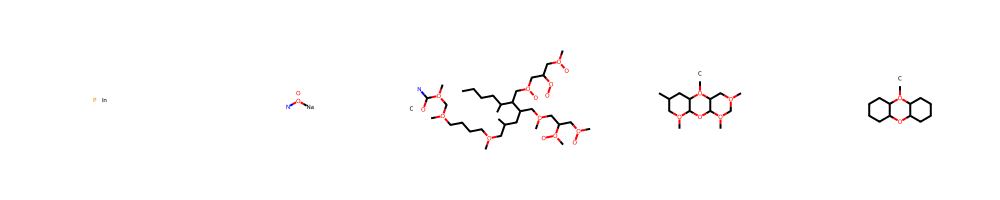

In [25]:
from IPython.display import display
from rdkit.Chem import Draw

# Pick 5 graphs, each graph individually represents a single molecule 
mols = [graph_to_molecule(G) for G in list(graphs.values())[:5]]

# Draw them
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))

# Show image
display(img)

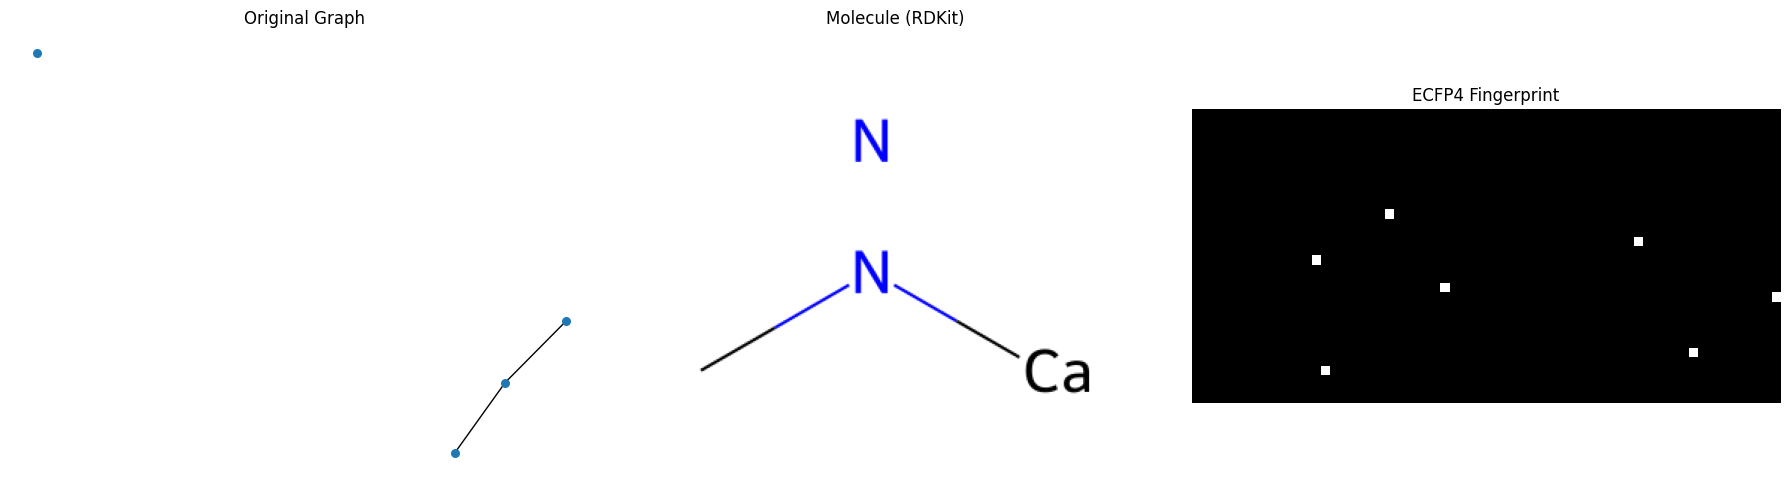

In [27]:
# Select the first graph
graph_id = list(graphs.keys())[-1]
G = graphs[graph_id]
fp = fingerprints[graph_id]

# Create molecule from graph
mol = graph_to_molecule(G)

# Prepare fingerprint image
fp_array = np.array(fp)
if fp_array.shape[0] == 2048:
    fp_image = fp_array.reshape(32, 64)
else:
    side = int(np.ceil(np.sqrt(len(fp_array))))
    padded_fp = np.zeros(side * side)
    padded_fp[:len(fp_array)] = fp_array
    fp_image = padded_fp.reshape((side, side))

# Generate the molecule drawing
mol_img = Draw.MolToImage(mol, size=(300, 300))

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Plot the original graph
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=False, node_size=30, ax=axs[0])
axs[0].set_title('Original Graph')
axs[0].axis('off')

# 2. Show molecule image
axs[1].imshow(mol_img)
axs[1].axis('off')
axs[1].set_title('Molecule (RDKit)')

# 3. Show fingerprint image
axs[2].imshow(fp_image, cmap='gray')
axs[2].axis('off')
axs[2].set_title('ECFP4 Fingerprint')

plt.tight_layout()
plt.show()

In [28]:
# ========== Save Fingerprints ==========
fp_array = np.array([list(fp.ToBitString()) for fp in fingerprints.values()], dtype=int)
print(fp_array.shape) 

(344, 2048)


In [29]:
# ========== Compute Graph Theoretical Features ==========
def compute_graph_features(G):
    features = {}

    # Basic metrics
    features['num_nodes'] = G.number_of_nodes()
    features['num_edges'] = G.number_of_edges()

    # Density
    features['density'] = nx.density(G)

    # Degree stats
    degrees = [deg for node, deg in G.degree()]
    features['degree_mean'] = np.mean(degrees)
    features['degree_std'] = np.std(degrees)
    features['degree_max'] = np.max(degrees)
    features['degree_min'] = np.min(degrees)

    # Clustering coefficient
    features['avg_clustering'] = nx.average_clustering(G)

    # Shortest-path metrics
    if nx.is_connected(G):
        features['diameter'] = nx.diameter(G)
        features['radius'] = nx.radius(G)
        features['avg_shortest_path'] = nx.average_shortest_path_length(G)
    else:
        # Use the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(largest_cc)
        features['diameter'] = nx.diameter(G_sub)
        features['radius'] = nx.radius(G_sub)
        features['avg_shortest_path'] = nx.average_shortest_path_length(G_sub)

    # SPID (Shortest Path Induced Diameter)
    sp_lengths = dict(nx.all_pairs_shortest_path_length(G))
    max_spl = max(max(lengths.values()) for lengths in sp_lengths.values())
    features['spid'] = max_spl

    return features

In [30]:
# ========== Get Graph Theoretical Features ==========
#graphs = {graph_id: networkx.Graph}
graph_features_list = []

for graph_id, G in graphs.items():
    feats = compute_graph_features(G)
    feats['graph_id'] = graph_id
    graph_features_list.append(feats)

# Convert to DataFrame
graph_features_df = pd.DataFrame(graph_features_list)
graph_features_df.set_index('graph_id', inplace=True)

print(graph_features_df.head())

          num_nodes  num_edges   density  degree_mean  degree_std  degree_max  \
graph_id                                                                        
1                 2          0  0.000000        0.000    0.000000           0   
2                 4          2  0.333333        1.000    0.707107           2   
3                50         48  0.039184        1.920    0.844748           3   
4                20         21  0.110526        2.100    0.943398           3   
5                16         17  0.141667        2.125    0.780625           3   

          degree_min  avg_clustering  diameter  radius  avg_shortest_path  \
graph_id                                                                    
1                  0             0.0         0       0           0.000000   
2                  0             0.0         2       1           1.333333   
3                  0             0.0        21      11           8.971088   
4                  0             0.0         8 

# Status: 
We have a set of fingerprints (fp) — one fingerprint vector per graph
Input to ML classifier must be a matrix X 
Fingerprints are not a matrix yet -> need to convert them 
Fingerprints are bit vectors (long 0/1 arrays (e.g., 2048 bits for Morgan))
Fingerprint matrix: Rows = molecules/graphs || Columns = fingerprint bits


In [31]:
fingerprint_rows = []
graph_ids = []

for graph_id, fp in fingerprints.items():
    arr = np.array(fp)  # RDKit bitvector to numpy array
    fingerprint_rows.append(arr)
    graph_ids.append(graph_id)

X_fingerprint = np.stack(fingerprint_rows)

# Create DataFrame
X_fingerprint_df = pd.DataFrame(X_fingerprint, index=graph_ids)
X_fingerprint_df.index.name = 'graph_id'

print(X_fingerprint_df.shape)
print(X_fingerprint_df.head())

(344, 2048)
          0     1     2     3     4     5     6     7     8     9     ...  \
graph_id                                                              ...   
1            0     0     0     0     0     0     0     0     0     0  ...   
2            0     0     0     0     0     0     0     0     0     0  ...   
3            0     0     0     0     0     0     0     0     0     0  ...   
4            0     0     0     0     0     0     0     0     0     0  ...   
5            0     0     0     0     0     0     0     0     0     0  ...   

          2038  2039  2040  2041  2042  2043  2044  2045  2046  2047  
graph_id                                                              
1            0     0     0     0     0     0     0     0     0     0  
2            0     0     0     0     0     0     0     0     0     0  
3            0     0     0     0     0     0     0     0     0     0  
4            0     0     0     0     0     0     0     0     0     0  
5            0     0  

In [32]:
density = X_fingerprint_df.values.sum() / X_fingerprint_df.size
print(f"Density: {density:.4f}")

Density: 0.0103


Very sparse X-matrix: 
Molecular fingerprints like ECFP4 (Morgan fingerprints) are designed to be sparse.
Many ML models work fine with sparse data
For DL often better to reduce dimension (e.g., PCA to 256 or 512)


In [33]:
X_fingerprint_df

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
graph_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
342,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
graph_labels.index = np.arange(1, len(graph_labels) + 1)
graph_labels.index.name = 'graph_id'

# Now you can access labels
y = graph_labels.loc[X_fingerprint_df.index]['graph_label'].values

print(X_fingerprint_df.shape)
print(y.shape)
print(np.unique(y))

(344, 2048)
(344,)
[-1  1]


# Training ML Classifiers

In [35]:
# Import all classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')


In [36]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'Support Vector Machine': SVC(probability=True),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Multi-Layer Perceptron': MLPClassifier(max_iter=1000)
}

In [37]:
# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
}

In [38]:
def is_binary_features(X):
        """
        Check if all features in the dataset are binary (contain only 0s and 1s).
        """
        return ((X == 0) | (X == 1)).all().all()

In [39]:
def evaluate_models(X, y, models_to_run, cv_strategy, scoring_metrics):
    """
    Train and evaluate multiple classifiers with cross-validation.
    
    Args:
        X (pd.DataFrame): Feature matrix
        y (np.array): Labels
        models_to_run (dict): Dictionary of model_name: sklearn model object
        cv_strategy (sklearn CV object): Cross-validation strategy
        scoring_metrics (dict): Dictionary of scorers
        
    Returns:
        pd.DataFrame: Results with mean and std of scores
    """
    results = []

    for name, model in models_to_run.items():
        
        if not is_binary_features(X):
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', model)
            ])
        else:
            pipeline = Pipeline([
                ('classifier', model)
            ])

        scores = {}
        for score_name, score_func in scoring_metrics.items():
            cv_scores = cross_val_score(pipeline, X, y, scoring=score_func, cv=cv_strategy)
            scores[f'{score_name}_mean'] = cv_scores.mean()
            scores[f'{score_name}_std'] = cv_scores.std()
        
        scores['model'] = name
        results.append(scores)
    
    return pd.DataFrame(results)

In [40]:
X_graphmetrics_df = graph_features_df.copy()

X_graphmetrics_df.columns = [col.lower() for col in X_graphmetrics_df.columns]

print(X_graphmetrics_df.shape)
print(X_graphmetrics_df.head())

(344, 12)
          num_nodes  num_edges   density  degree_mean  degree_std  degree_max  \
graph_id                                                                        
1                 2          0  0.000000        0.000    0.000000           0   
2                 4          2  0.333333        1.000    0.707107           2   
3                50         48  0.039184        1.920    0.844748           3   
4                20         21  0.110526        2.100    0.943398           3   
5                16         17  0.141667        2.125    0.780625           3   

          degree_min  avg_clustering  diameter  radius  avg_shortest_path  \
graph_id                                                                    
1                  0             0.0         0       0           0.000000   
2                  0             0.0         2       1           1.333333   
3                  0             0.0        21      11           8.971088   
4                  0             0.0 

In [42]:
# Join on graph_id index

X_combined_df = pd.concat([X_fingerprint_df, X_graphmetrics_df], axis=1)
X_combined_df.columns = X_combined_df.columns.astype(str)
print(X_combined_df.shape)
print(X_combined_df.head())

(344, 2060)
          0  1  2  3  4  5  6  7  8  9  ...   density  degree_mean  \
graph_id                                ...                          
1         0  0  0  0  0  0  0  0  0  0  ...  0.000000        0.000   
2         0  0  0  0  0  0  0  0  0  0  ...  0.333333        1.000   
3         0  0  0  0  0  0  0  0  0  0  ...  0.039184        1.920   
4         0  0  0  0  0  0  0  0  0  0  ...  0.110526        2.100   
5         0  0  0  0  0  0  0  0  0  0  ...  0.141667        2.125   

          degree_std  degree_max  degree_min  avg_clustering  diameter  \
graph_id                                                                 
1           0.000000           0           0             0.0         0   
2           0.707107           2           0             0.0         2   
3           0.844748           3           0             0.0        21   
4           0.943398           3           0             0.0         8   
5           0.780625           3           0         

In [43]:
models_lr = {'Logistic Regression': LogisticRegression(max_iter=1000)}

# Evaluate on fingerprints
results_fingerprint = evaluate_models(X_fingerprint_df, y, models_lr, cv, scoring)
# Evaluate on graph metrics
results_graph = evaluate_models(X_graphmetrics_df, y, models_lr, cv, scoring)
# Evaluate on combined features
results_combined = evaluate_models(X_combined_df, y, models_lr, cv, scoring)

print("--- Fingerprints ---")
print(results_fingerprint)
print("\n--- Graph Metrics ---")
print(results_graph)
print("\n--- Combined ---")
print(results_combined)

--- Fingerprints ---
   accuracy_mean  accuracy_std  roc_auc_mean  roc_auc_std                model
0       0.595951      0.033233      0.606667     0.050713  Logistic Regression

--- Graph Metrics ---
   accuracy_mean  accuracy_std  roc_auc_mean  roc_auc_std                model
0       0.584314      0.014261      0.588092     0.040268  Logistic Regression

--- Combined ---
   accuracy_mean  accuracy_std  roc_auc_mean  roc_auc_std                model
0       0.566965      0.059651      0.577781      0.07371  Logistic Regression


In [44]:
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier,
    RandomForestClassifier, ExtraTreesClassifier
)
from sklearn.neural_network import MLPClassifier

# Define classifiers
models = {
    "Logistic Regression (LR)": LogisticRegression(max_iter=1000),
    "Linear Discriminant Analysis (LDA)": LinearDiscriminantAnalysis(),
    "K-Nearest Neighbor (KNN)": KNeighborsClassifier(),
    "Decision Tree (CART)": DecisionTreeClassifier(),
    "Naïve Bayes (NB)": GaussianNB(),
    "Support Vector Machine (SVM)": SVC(probability=True),
    "AdaBoost (AB)": AdaBoostClassifier(),
    "Gradient Boosting (GBM)": GradientBoostingClassifier(),
    "Random Forest (RF)": RandomForestClassifier(),
    "Extra Trees (ET)": ExtraTreesClassifier(),
    "Multi-Layer Perceptron (MLP)": MLPClassifier(max_iter=1000)
}

# Define datasets
datasets = {
    "Fingerprints": X_fingerprint_df,
    "Graph Metrics": X_graphmetrics_df,
    "Combined": X_combined_df,
}

# Evaluation settings
scoring = ['accuracy', 'roc_auc']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Helper to check for binary-only features
def is_binary_features(df):
    return ((df == 0) | (df == 1)).all().all()

# Run evaluations
all_results = {}
for dataset_name, X_use in datasets.items():
    print(f"\n=== Running models on: {dataset_name} (shape: {X_use.shape}) ===")
    results = []

    for name, model in models.items():
        print(f"\nRunning: {name}")
        start_time = time.time()

        # Scale non-binary features
        if not is_binary_features(X_use):
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', model)
            ])
        else:
            pipeline = Pipeline([
                ('clf', model)
            ])

        model_scores = {}
        for score_metric in scoring:
            cv_scores = cross_val_score(pipeline, X_use, y, scoring=score_metric, cv=cv)
            model_scores[f"{score_metric}_mean"] = cv_scores.mean()
            model_scores[f"{score_metric}_std"] = cv_scores.std()

        elapsed_time = time.time() - start_time

        print(f"Accuracy: {model_scores['accuracy_mean']:.4f} ± {model_scores['accuracy_std']:.4f}")
        print(f"ROC AUC: {model_scores['roc_auc_mean']:.4f} ± {model_scores['roc_auc_std']:.4f}")
        print(f"Training Time: {elapsed_time:.2f} seconds")

        results.append({
            'model': name,
            **model_scores,
            'time_sec': elapsed_time
        })

    # Save for analysis
    results_df = pd.DataFrame(results).sort_values('roc_auc_mean', ascending=False)
    all_results[dataset_name] = results_df


=== Running models on: Fingerprints (shape: (344, 2048)) ===

Running: Logistic Regression (LR)
Accuracy: 0.5960 ± 0.0332
ROC AUC: 0.6067 ± 0.0507
Training Time: 0.21 seconds

Running: Linear Discriminant Analysis (LDA)
Accuracy: 0.5406 ± 0.0593
ROC AUC: 0.5525 ± 0.0728
Training Time: 0.67 seconds

Running: K-Nearest Neighbor (KNN)
Accuracy: 0.5000 ± 0.0430
ROC AUC: 0.5491 ± 0.0876
Training Time: 0.14 seconds

Running: Decision Tree (CART)
Accuracy: 0.5697 ± 0.0752
ROC AUC: 0.5892 ± 0.0812
Training Time: 0.20 seconds

Running: Naïve Bayes (NB)
Accuracy: 0.5843 ± 0.0525
ROC AUC: 0.5913 ± 0.0555
Training Time: 0.15 seconds

Running: Support Vector Machine (SVM)
Accuracy: 0.6250 ± 0.0569
ROC AUC: 0.6349 ± 0.0548
Training Time: 1.81 seconds

Running: AdaBoost (AB)
Accuracy: 0.5960 ± 0.0364
ROC AUC: 0.5980 ± 0.0249
Training Time: 1.65 seconds

Running: Gradient Boosting (GBM)
Accuracy: 0.5902 ± 0.0542
ROC AUC: 0.6017 ± 0.0497
Training Time: 2.96 seconds

Running: Random Forest (RF)
Accurac

=== Final Results ===
                                 model  accuracy_mean  accuracy_std  \
0             Logistic Regression (LR)       0.797621      0.032588   
10        Multi-Layer Perceptron (MLP)       0.796297      0.008762   
7              Gradient Boosting (GBM)       0.793682      0.038512   
8                   Random Forest (RF)       0.785744      0.040342   
5         Support Vector Machine (SVM)       0.788376      0.041160   
2             K-Nearest Neighbor (KNN)       0.780507      0.055670   
9                     Extra Trees (ET)       0.775157      0.047993   
6                        AdaBoost (AB)       0.777771      0.038559   
3                 Decision Tree (CART)       0.750061      0.050835   
1   Linear Discriminant Analysis (LDA)       0.709062      0.057017   
4                     Naïve Bayes (NB)       0.709010      0.038486   

    roc_auc_mean  roc_auc_std   time_sec  
0       0.875359     0.030003   0.840698  
10      0.865152     0.026959  12.689475  
7       0.863160     0.031335   8.300434  
8       0.861940     0.032218   1.500110  
5       0.859565     0.038361   7.157297  
2       0.850398     0.037423   0.186665  
9       0.848321     0.032992   1.677692  
6       0.841759     0.033705   3.054541  
3       0.752207     0.038868   0.443390  
1       0.735154     0.068318   1.729279  
4       0.696695     0.042112   0.212836

In [ ]:
all_results

{'Fingerprints':                                  model  accuracy_mean  accuracy_std  \
 5         Support Vector Machine (SVM)         0.9895      0.002915   
 0             Logistic Regression (LR)         0.9810      0.005612   
 8                   Random Forest (RF)         0.9455      0.007810   
 9                     Extra Trees (ET)         0.9505      0.004848   
 7              Gradient Boosting (GBM)         0.9640      0.004062   
 6                        AdaBoost (AB)         0.9625      0.009083   
 10        Multi-Layer Perceptron (MLP)         0.9290      0.009301   
 3                 Decision Tree (CART)         0.9160      0.009566   
 2             K-Nearest Neighbor (KNN)         0.8520      0.006205   
 1   Linear Discriminant Analysis (LDA)         0.7695      0.031992   
 4                     Naïve Bayes (NB)         0.5455      0.031796   
 
     roc_auc_mean  roc_auc_std   time_sec  
 5       0.992852     0.005332  22.231395  
 0       0.992234     0.005264

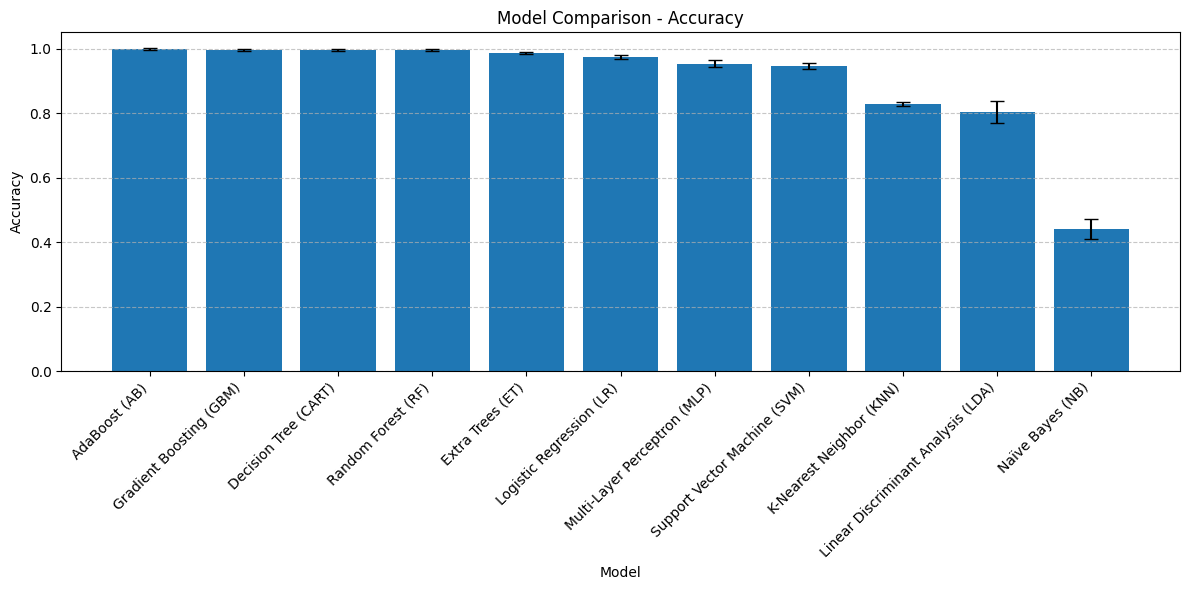

In [ ]:
# Sort by accuracy for better readability
results_df_sorted = results_df.sort_values('accuracy_mean', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(results_df_sorted['model'], results_df_sorted['accuracy_mean'], yerr=results_df_sorted['accuracy_std'], capsize=5)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Model Comparison - Accuracy')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [46]:
import pandas as pd

all_results = {
    'Fingerprints': pd.DataFrame({
        'model': [
            "Support Vector Machine (SVM)", "Logistic Regression (LR)", "Random Forest (RF)",
            "Extra Trees (ET)", "Gradient Boosting (GBM)", "AdaBoost (AB)",
            "Multi-Layer Perceptron (MLP)", "Decision Tree (CART)", "K-Nearest Neighbor (KNN)",
            "Linear Discriminant Analysis (LDA)", "Naïve Bayes (NB)"
        ],
        'accuracy_mean': [0.6250, 0.5960, 0.5784, 0.6104, 0.5902, 0.5960, 0.5639, 0.5697, 0.5000, 0.5406, 0.5843],
        'accuracy_std': [0.0569, 0.0332, 0.0710, 0.0384, 0.0542, 0.0364, 0.0551, 0.0752, 0.0430, 0.0593, 0.0525],
        'roc_auc_mean': [0.6349, 0.6067, 0.6137, 0.6066, 0.6017, 0.5980, 0.5908, 0.5892, 0.5491, 0.5525, 0.5913],
        'roc_auc_std': [0.0548, 0.0507, 0.0742, 0.0838, 0.0497, 0.0249, 0.0807, 0.0812, 0.0876, 0.0728, 0.0555],
        'time_sec': [1.81, 0.21, 1.12, 1.19, 2.96, 1.65, 15.55, 0.20, 0.14, 0.67, 0.15]
    }),

    'Graph Metrics': pd.DataFrame({
        'model': [
            "Support Vector Machine (SVM)", "Logistic Regression (LR)", "Random Forest (RF)",
            "Extra Trees (ET)", "Gradient Boosting (GBM)", "AdaBoost (AB)",
            "Multi-Layer Perceptron (MLP)", "Decision Tree (CART)", "K-Nearest Neighbor (KNN)",
            "Linear Discriminant Analysis (LDA)", "Naïve Bayes (NB)"
        ],
        'accuracy_mean': [0.5784, 0.5843, 0.5611, 0.5494, 0.5494, 0.5611, 0.5728, 0.5464, 0.5640, 0.5699, 0.5843],
        'accuracy_std': [0.0234, 0.0143, 0.0242, 0.0253, 0.0562, 0.0224, 0.0280, 0.0738, 0.0346, 0.0529, 0.0193],
        'roc_auc_mean': [0.6151, 0.5881, 0.5832, 0.5771, 0.6004, 0.5829, 0.5976, 0.5473, 0.5938, 0.5778, 0.6082],
        'roc_auc_std': [0.0334, 0.0403, 0.0496, 0.0433, 0.0481, 0.0393, 0.0673, 0.0759, 0.0328, 0.0472, 0.0397],
        'time_sec': [0.10, 0.03, 0.62, 0.47, 0.61, 0.37, 2.80, 0.03, 0.03, 0.03, 0.02]
    }),

    'Combined': pd.DataFrame({
        'model': [
            "Support Vector Machine (SVM)", "Logistic Regression (LR)", "Random Forest (RF)",
            "Extra Trees (ET)", "Gradient Boosting (GBM)", "AdaBoost (AB)",
            "Multi-Layer Perceptron (MLP)", "Decision Tree (CART)", "K-Nearest Neighbor (KNN)",
            "Linear Discriminant Analysis (LDA)", "Naïve Bayes (NB)"
        ],
        'accuracy_mean': [0.5902, 0.5670, 0.6192, 0.6017, 0.6193, 0.6133, 0.5436, 0.6073, 0.5840, 0.5610, 0.5755],
        'accuracy_std': [0.0439, 0.0597, 0.0704, 0.0641, 0.0720, 0.0287, 0.0628, 0.0881, 0.0639, 0.0604, 0.0541],
        'roc_auc_mean': [0.6255, 0.5778, 0.6311, 0.6138, 0.6279, 0.6116, 0.6032, 0.6002, 0.6274, 0.5511, 0.5830],
        'roc_auc_std': [0.0907, 0.0737, 0.0639, 0.0681, 0.0678, 0.0155, 0.0857, 0.0915, 0.0785, 0.0666, 0.0564],
        'time_sec': [2.04, 0.34, 1.14, 1.22, 2.82, 1.52, 12.85, 0.33, 0.27, 0.76, 0.25]
    })
}


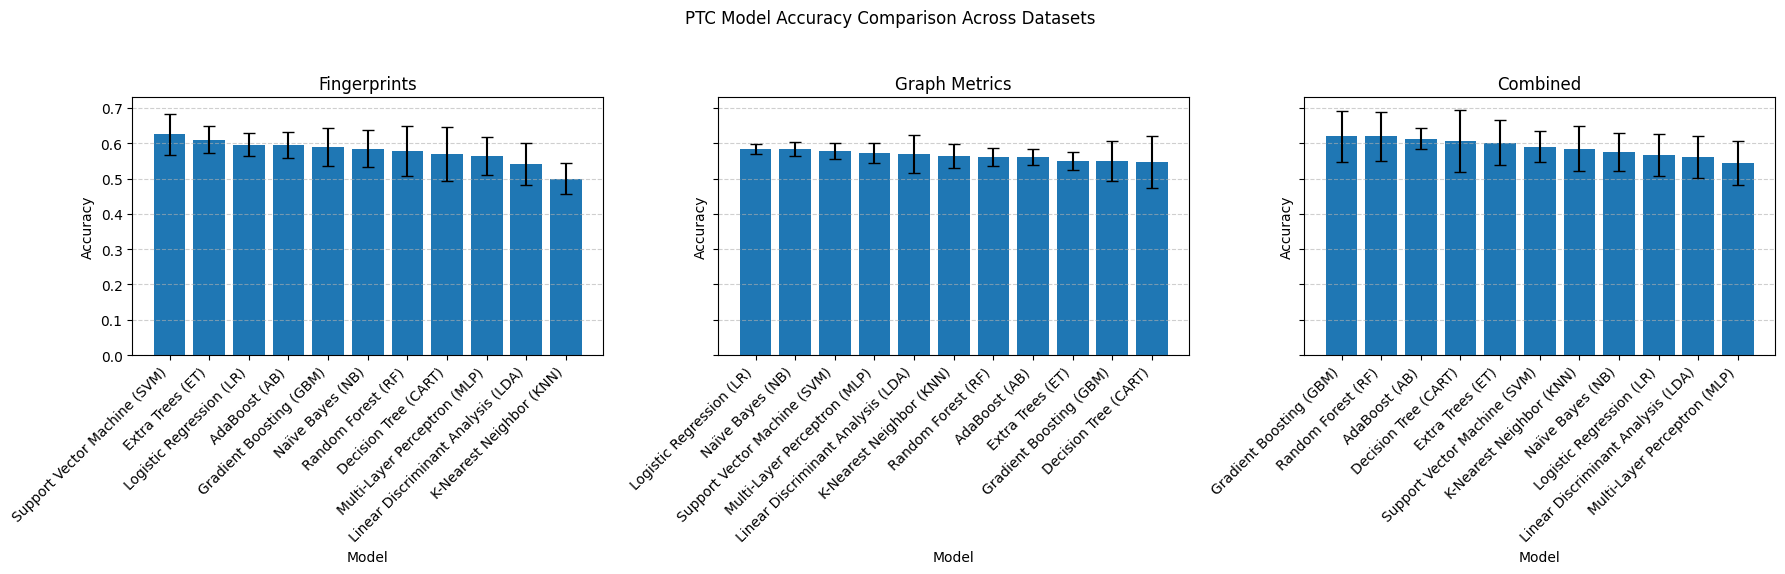

In [48]:
import matplotlib.pyplot as plt

# Plot settings
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs = axs.flatten()  # Flatten to 1D array for easy iteration

for ax, (dataset_name, df) in zip(axs, all_results.items()):
    df_sorted = df.sort_values('accuracy_mean', ascending=False)
    ax.bar(df_sorted['model'], df_sorted['accuracy_mean'], yerr=df_sorted['accuracy_std'], capsize=4)
    ax.set_title(f"{dataset_name}")
    ax.set_xlabel("Model")
    ax.set_ylabel("Accuracy")
    ax.set_xticklabels(df_sorted['model'], rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle("PTC Model Accuracy Comparison Across Datasets")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()